In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd

#from sklearn import OneHotEncoder

# per importare cose nella folder precedente da ora in poi
import sys
sys.path.append('../')

from layer import HiddenLayer
from activations import *
from losses import *
from network import Network
from regularizers import *
from utils import *
from metrics import *
from validation import *

random.seed(42)
np.random.seed(42)

# Progress bar
from tqdm import tqdm
import time

In [2]:
X_train, y_train, test = read_cup("../data/ML-CUP23-TR.csv", "../data/ML-CUP23-TS.csv")

In [7]:
seed = 3
np.random.seed(seed)
net = Network(MSE(1), eta=1e-4)

net.add_layer(
    input_size=len(X_train[0]),
    units_size=16,
    starting=Range_random(),
    regularizer=L2(lambda_=1e-6),
    activation=ReLU(),
    momentum=('Standard',1e-5)
)


net.add_layer(
    input_size=16,
    units_size=16,
    starting=Range_random(),
    regularizer=L2(lambda_=1e-6),
    activation=Identity(),
    momentum=('Standard',1e-5)
)
net.add_layer(
    input_size=16,
    units_size=3,
    starting=Range_random(),
    regularizer=L2(lambda_=1e-6),
    activation=Identity(),
    momentum=('Standard',1e-5)
)

In [3]:
seed = 3

net = create_all_net(
    seed=seed,
    loss="MSE",
    batch_size=1,
    input_size=len(X_train[0]),
    num_layer=3,
    layers_size=[16,16,3],
    starting=["Range_random", "Range_random", "Range_random"],
    starting_range=[(-0.5,0.5),(-0.5,0.5),(-0.5,0.5)],
    activations=["ReLU", "ReLU", "Identity"],
    regularizers=["L2", "L2", "L2"],
    regularizers_lambda=[1e-6,1e-6,1e-6],
    momentums=[("Standard", 1e-5), ("Standard", 1e-5), ("Standard", 1e-5)],
    eta=1e-4
)

In [9]:
loss = "MSE"
batch_size = 1

loss = eval(loss)(batch_size=batch_size)
loss

In [8]:
print(net)
type(net.loss)


Network: 3 layers 
Loss: MSE


str

Epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

Epochs: 100%|██████████| 1000/1000 [02:05<00:00,  7.96it/s]


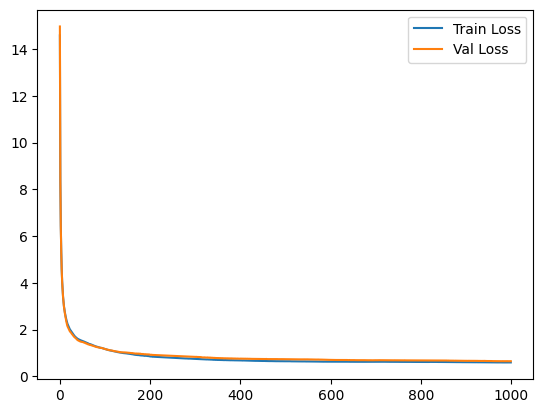

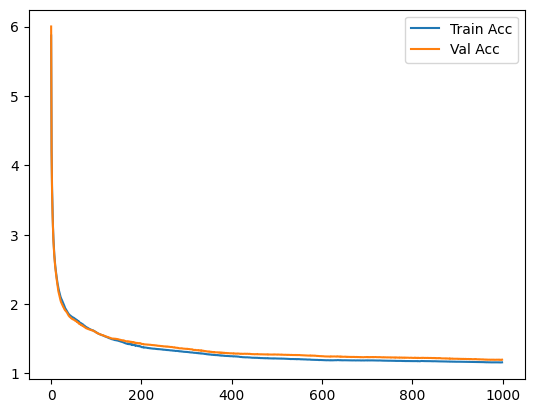

Epochs:  90%|████████▉ | 896/1000 [01:49<00:12,  8.15it/s]


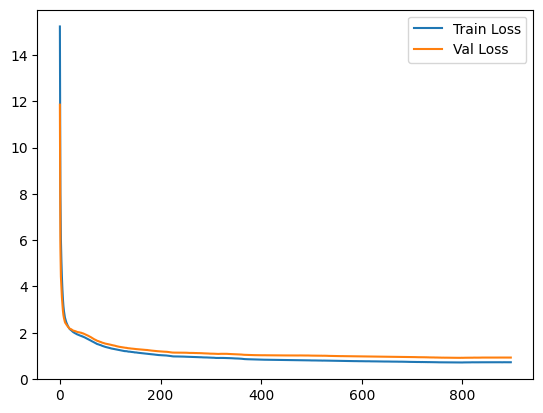

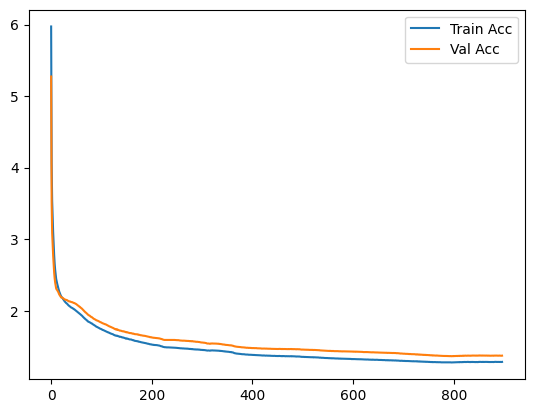

Epochs: 100%|██████████| 1000/1000 [02:04<00:00,  8.02it/s]


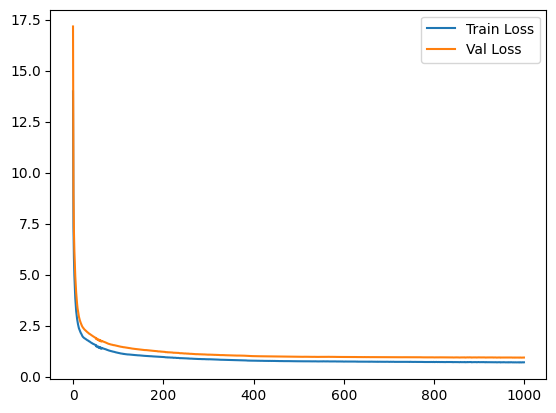

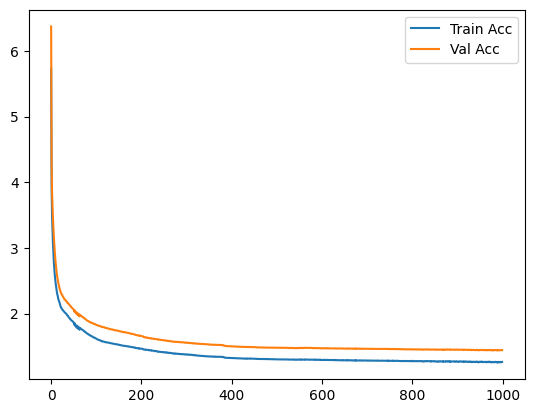

Epochs: 100%|██████████| 1000/1000 [02:06<00:00,  7.91it/s]


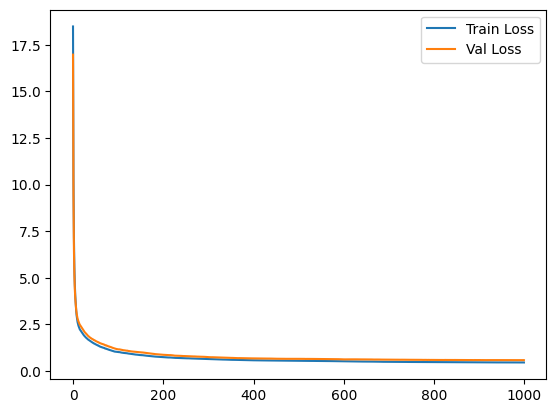

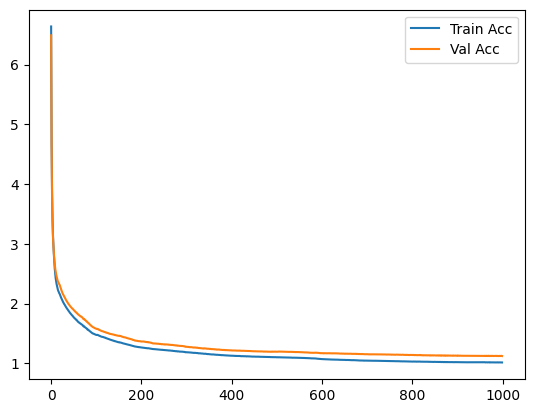

Epochs: 100%|██████████| 1000/1000 [02:11<00:00,  7.62it/s]


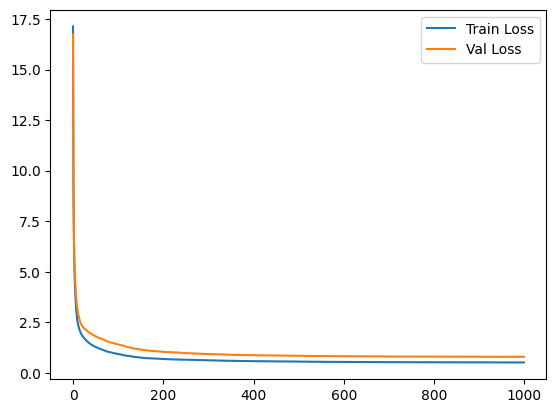

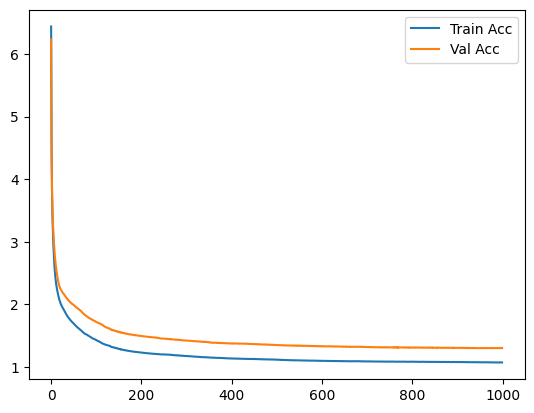

Epochs: 100%|██████████| 1000/1000 [02:07<00:00,  7.83it/s]


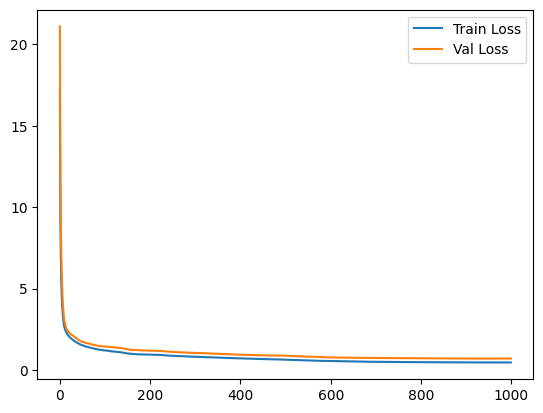

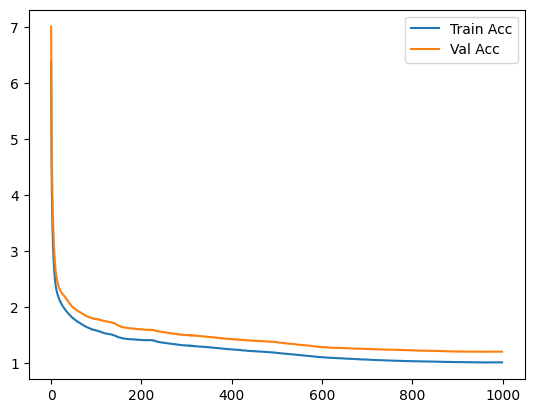

{'tr_loss': 0.5769497889488097, 'tr_metric': 1.1343255652294013, 'val_loss': 0.766164979430448, 'val_metric': 1.2738891093680855}


In [4]:
statistics = kfold_crossval(
    X=X_train,
    y=y_train,
    k=6,
    net=net,
    epochs=1000,
    patience=100,
    seed=seed,
    metric=MEE()
)

print(statistics)

In [5]:
for i in net.layers:
    print(i)

Hidden layer of 5 units.

Input size: 10
Starting: Random uniform in range [-0.5, 0.5]
Activation: ReLU
Regularizer: None
Momentum: Standard with alpha 1e-05

W = 
[[ 0.83206476 -1.6753159   0.97702059  0.52412492  3.08993397]
 [-0.13913778  2.40239724 -1.87972633 -0.7912416   1.16859764]
 [-0.16303234 -1.24580828 -0.33008676  1.04173321  1.98063721]
 [ 0.61886498 -0.01553527 -1.58006535 -0.06744937 -1.22084517]
 [ 0.25497981 -0.81036219  1.83507096  0.33917393 -1.44427828]
 [ 1.40660792 -2.17773499  0.6488325  -0.59298745 -0.6423085 ]
 [-2.27951298 -1.066875    0.35399713  0.91894149 -0.61573236]
 [ 0.74074659 -0.04557695 -0.86318026  0.05810358  0.78498237]
 [-1.12283959 -2.48107591  0.17004747 -0.40462648 -2.48993885]
 [-0.65083527  1.63392658  1.82602486  0.02808019 -6.09632333]]

b = 
[[2.88019816]
 [2.87616653]
 [3.18882287]
 [2.76201718]
 [3.15837335]])
Hidden layer of 3 units.

Input size: 5
Starting: Random uniform in range [-0.5, 0.5]
Activation: Identity
Regularizer: None
Mo

In [6]:
for i, layer in enumerate(net.layers):
    print(i , layer)

0 Hidden layer of 5 units.

Input size: 10
Starting: Random uniform in range [-0.5, 0.5]
Activation: ReLU
Regularizer: None
Momentum: Standard with alpha 1e-05

W = 
[[ 0.83206476 -1.6753159   0.97702059  0.52412492  3.08993397]
 [-0.13913778  2.40239724 -1.87972633 -0.7912416   1.16859764]
 [-0.16303234 -1.24580828 -0.33008676  1.04173321  1.98063721]
 [ 0.61886498 -0.01553527 -1.58006535 -0.06744937 -1.22084517]
 [ 0.25497981 -0.81036219  1.83507096  0.33917393 -1.44427828]
 [ 1.40660792 -2.17773499  0.6488325  -0.59298745 -0.6423085 ]
 [-2.27951298 -1.066875    0.35399713  0.91894149 -0.61573236]
 [ 0.74074659 -0.04557695 -0.86318026  0.05810358  0.78498237]
 [-1.12283959 -2.48107591  0.17004747 -0.40462648 -2.48993885]
 [-0.65083527  1.63392658  1.82602486  0.02808019 -6.09632333]]

b = 
[[2.88019816]
 [2.87616653]
 [3.18882287]
 [2.76201718]
 [3.15837335]])
1 Hidden layer of 3 units.

Input size: 5
Starting: Random uniform in range [-0.5, 0.5]
Activation: Identity
Regularizer: Non